# Task 3

## Imports

In [573]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

## Reading data

Using pandas we read the csv file and store it in a dataframe.

In [574]:
# read flight.csv
df = pd.read_csv('data/flight.csv')

Calling info() we can see that most data types are wrong

In [575]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121427 entries, 0 to 121426
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unnamed: 0      121427 non-null  int64 
 1   datetime_val    121427 non-null  object
 2   dep_time        121427 non-null  object
 3   arr_time        121427 non-null  object
 4   sched_arr_time  121427 non-null  object
 5   flight          121427 non-null  int64 
 6   origin          121427 non-null  object
 7   dest            121427 non-null  object
dtypes: int64(2), object(6)
memory usage: 7.4+ MB


## Converting data types

In order to convert the data types we use the to_datetime() function from pandas

In [576]:
df['datetime_val'] = pd.to_datetime(df['datetime_val'])
df['dep_time'] = pd.to_datetime(df['dep_time'], errors='coerce')
df['arr_time'] = pd.to_datetime(df['arr_time'], errors='coerce')
df['sched_arr_time'] = pd.to_datetime(df['sched_arr_time'])

Printing info again we can see that the data types are now correct

In [577]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121427 entries, 0 to 121426
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Unnamed: 0      121427 non-null  int64         
 1   datetime_val    121427 non-null  datetime64[ns]
 2   dep_time        121421 non-null  datetime64[ns]
 3   arr_time        121379 non-null  datetime64[ns]
 4   sched_arr_time  121427 non-null  datetime64[ns]
 5   flight          121427 non-null  int64         
 6   origin          121427 non-null  object        
 7   dest            121427 non-null  object        
dtypes: datetime64[ns](4), int64(2), object(2)
memory usage: 7.4+ MB


## Correcting errors

In order to correct errors in the dataset we have to check that arrival time is after departure time, and if not we have to add 24 hours to the arrival time.

In [578]:
def fix_errors():
    # Loop over all rows in the dataframe
    for index, row in df.iterrows():
        # Check if arr_time is less than dep_time
        if (row['arr_time'] < row['dep_time']):
            # Add 1 day to arr_time
            df.loc[index, 'arr_time'] = (row['arr_time']) + datetime.timedelta(days=1)

# Call the function
fix_errors()

The proposed solution also checks if the scheduled departure time is after the scheduled arrival time, and adds 24 hours to the arrival time if this is the case.

This does not make sense as delays are not taken into account. If a flight is delayed for longer than the flight time, the arrival time will be before the departure time.

We opt to not correct this error as it could introduce even more errors.

In [579]:
def fix_but_introduce_errors():
    # Loop over all rows in the dataframe
    for index, row in df.iterrows():
        # Check if sched_arr_time is less than dep_time
        if (row['sched_arr_time'] < row['dep_time']):
            # Add 1 day to sched_arr_time
            df.loc[index, 'sched_arr_time'] = (row['sched_arr_time']) + datetime.timedelta(days=1)

# Air time

We calculate air time by subtracting departure time from arrival time.

In [580]:
# Calculate air_time
df['air_time'] = df["arr_time"] - df["dep_time"]

We call describe() to check that our values are reasonable.

If we were to comment out the call to fix_errors() above, we would see that the minimum air time is negative, which is not possible.

In [581]:
df['air_time'].describe()

count                       121373
mean     0 days 02:24:35.250673543
std      0 days 00:48:21.085119025
min                0 days 00:44:00
25%                0 days 01:44:00
50%                0 days 02:35:00
75%                0 days 03:01:00
max                0 days 06:21:00
Name: air_time, dtype: object

We calculate delay by subtracting scheduled departure time from actual departure time.

In [582]:
# Calculate delay
df['delay'] = df["arr_time"] - df["sched_arr_time"]

Again we call describe() to check that our values are reasonable.

In [583]:
df['delay'].describe()

count                       121379
mean     0 days 00:28:54.285172888
std      0 days 03:21:20.312224371
min              -1 days +01:03:00
25%              -1 days +23:43:00
50%              -1 days +23:54:00
75%                0 days 00:13:00
max                1 days 02:58:00
Name: delay, dtype: object

Some of the values look suspicious, and we inspect further by looking at the minimum value.

In [584]:
df.iloc[df['delay'].argmin()]

Unnamed: 0                      68111
datetime_val      2013-04-23 22:50:00
dep_time          2013-04-23 00:05:00
arr_time          2013-04-23 01:01:00
sched_arr_time    2013-04-23 23:58:00
flight                           1018
origin                            JFK
dest                              BOS
air_time              0 days 00:56:00
delay               -1 days +01:03:00
Name: 66730, dtype: object

 We see that the reason for the negative value is that the plane was delayed past midnight, but the dates were not updated. We could implement a function to fix errors like this, but it is hard to reason about what the correct values should be without looking at all the fields. Instead we will remove these outliers later.

## Calculating percentage delay

We calculate the percentage delay by dividing the delay by the air time and multiplying by 100.

In [585]:
# Calculate percent_delay
df['percent_delay'] = (df['delay']) / (df['air_time']) * 100

We plot the percentage delay to have a look at the outliers.

<Axes: >

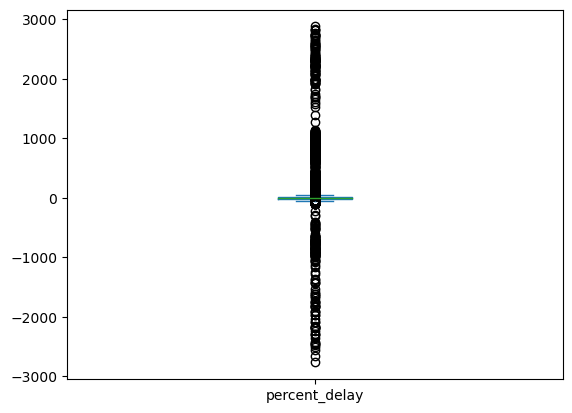

In [586]:
df['percent_delay'].plot.box()

As we can se from the plot there are a lot of outliers, and we will remove these.

In [587]:
# Function to remove outliers outside the 5th and 95th percentile
def remove_outlier(df):
    low = .05 # 5th percentile
    high = .95 # 95th percentile

    # Calculate quantile
    quant_df = df.quantile([low, high])

    if is_numeric_dtype(df):
        # Remove outliers using the quantiles
        df = df[(df > quant_df.loc[low]) & (df < quant_df.loc[high])]
    return df

In [588]:

# Using the remove_outliers() function
df['percent_delay'] = remove_outlier(df['percent_delay'])

When describing the percentage delay again we see that the values are much more reasonable after removing the outliers.

In [589]:
df['percent_delay'].describe()

count    109215.000000
mean         -0.612583
std          18.752958
min         -32.758621
25%         -12.582781
50%          -3.846154
75%           6.593407
max          77.297297
Name: percent_delay, dtype: float64

Same with the box plot

<Axes: >

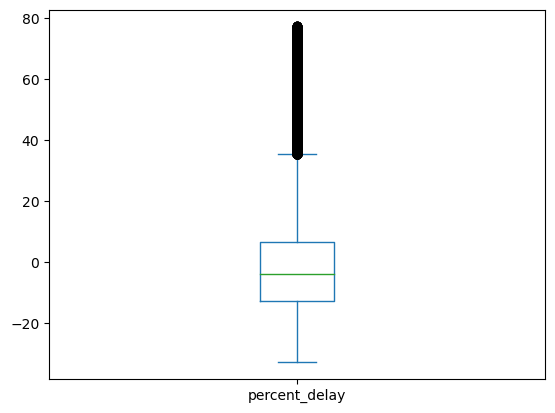

In [590]:
df['percent_delay'].plot.box()

## Charts

<Axes: title={'center': 'Percent Delayed'}, xlabel='percentage of delay', ylabel='total'>

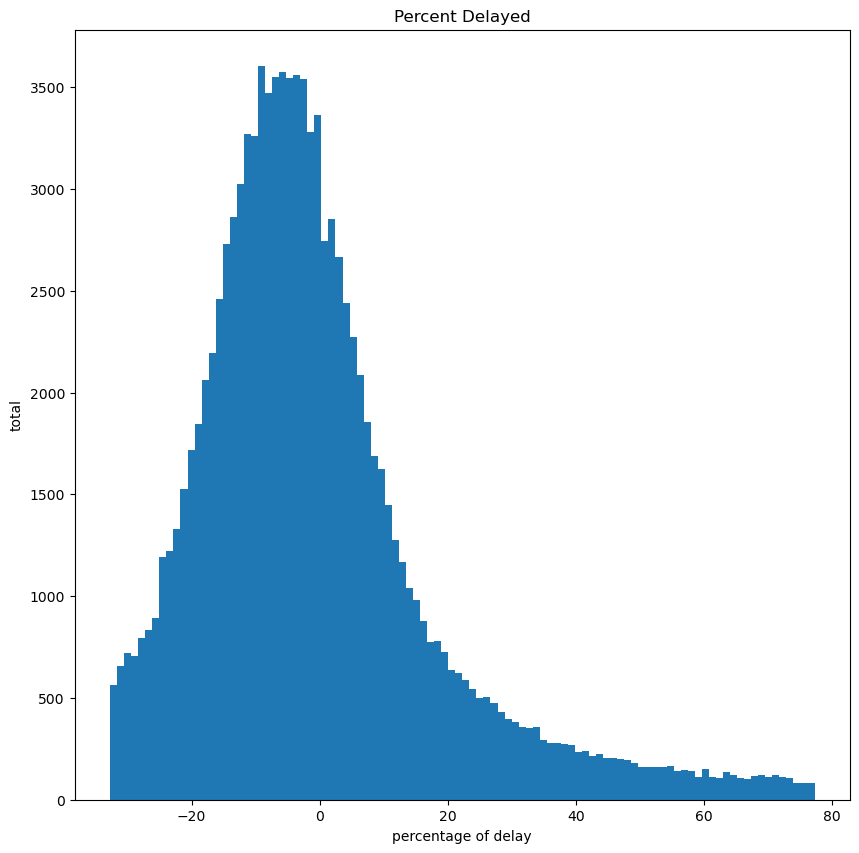

In [591]:
# Histogram of percent_delay
df['percent_delay'].plot.hist(bins=100, figsize=(10,10), title='Percent Delayed', ylabel="total", xlabel="percentage of delay")


When looking at the histogram we can clearly see where we removed the outliers. We also get a sense of how many flights are delayed. It would perhaps be better to call it something other than delay as it includes both positive and negative deviations from the scheduled arrival time.